# Matrix Analysis 2022 - EE312

## Week 4 - Image deblurring using right inverse
[LTS2](https://lts2.epfl.ch)



## Exercises
Exercises are mandatory for BA6 students, optional (but yet highly recommended) for BA4 students.
### 1.
Let $A \in \mathbb{R}^{m \times n}$ and suppose it has a left-inverse. Prove that $A^T$ has a right-inverse.

Let us denote by $A_L^{-1}$ the left inverse of $A$. Therefore we have $A_L^{-1}A=I$. If we apply the transpose operator we have 

$(A_L^{-1}A)^T=I=A^T(A_L^{-1})^T$. Therefore $A^T$ has a right-inverse $A_R^{-1}=(A_L^{-1})^T$.

---

### 2.
Let $A=\begin{pmatrix}1 & 1 & 1 &0\\1 & 2 & 2 & 1\\2 & 5 & 5 & 3\end{pmatrix}$

Compute a basis for each of its four fundamental subspaces.

We can see that the middle columns are equal, and also that they are the sum of the first and last columns. 
The rank of $A$ is equal to 2, and we can choose the first and last columns as basis vectors for $\mathcal{R}(A)$:

$\begin{pmatrix}1\\1\\2\end{pmatrix}$ and $\begin{pmatrix}0\\1\\3\end{pmatrix}$.

We have $\mathcal{R}(A)\perp\mathcal{N}(A^T)=\mathcal{R}(A)^\perp$. The dimension of $\mathcal{R}(A)^\perp$ is equal to 1, and solving for a vector orthogonal to the vectors defined above yields the following system to solve:

$x + y + 2z = 0$ and $y + 3z = 0$. 

Subtracting the two equations yields $x-z=0$, hence $x=z$. 
The admissible solutions are not unique, we can choose for instance $\begin{pmatrix}1\\-3\\1\end{pmatrix}$. 

Now considering the rows of $A$, the rank being 2 (the last row is equal to 3 times the second row minus the first row) we can pick for instance the first two rows as basis for $\mathcal{R}(A^T)$ 

$\begin{pmatrix}1\\1\\1\\0\end{pmatrix}$ and $\begin{pmatrix}1\\2\\2\\1\end{pmatrix}$.

Since $\mathcal{N}(A)\perp\mathcal{R}(A^T)$, $\dim\mathcal{N}(A)=2$. We need to find two independent vectors that satisfy:

$x+y+z=0$ and $x+2y+2z+t=0$. Subtracting the second equation from twice the first yields $x - t=0$ hence $x=t$.

A possible combination is 

$\begin{pmatrix}-2\\1\\1\\-2\end{pmatrix}$ and $\begin{pmatrix}0\\-1\\1\\0\end{pmatrix}$.

## Image deblurring

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.transform
import os

In [105]:
filename = os.path.join(skimage.data_dir, 'camera.png')
camera = skimage.io.imread(filename)

In [106]:
camera.shape

(512, 512)

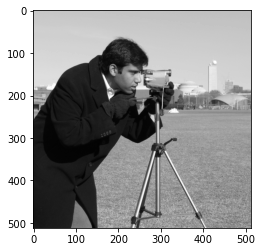

In [107]:
plt.imshow(camera, cmap='gray')

### 1. Blurring operator

In [2]:
def blur_matrix(N, p, s):
    M = N//s
    B = np.zeros((M, N))
    for k in range(M):
        # use zero padding as boundary conditions
        lwr_bound = max(0, k*s - p)
        upper_bound = min(N, k*s + p+1)
        br = np.arange(lwr_bound, upper_bound)
        B[k, br] = np.ones(len(br))/(2*p+1)
       
    return B

If the parameters are chosen s.t. there is no 0 columns (that is if you subsample not too agressively, i.e. if $s\leq2p+1$) the rank of $B$ will be $M$ (all the rows are clearly independent), i.e. the matrix is onto and has a right inverse.

In [140]:
B=blur_matrix(512, 3, 2)

### 2. Blurring

In [141]:
#apply on columns
camera_c = B@camera

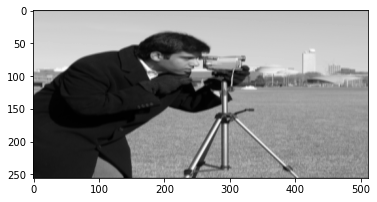

In [142]:
plt.imshow(camera_c, cmap='gray')

In [143]:
# apply on rows
camera_blurred = (B@camera_c.T).T

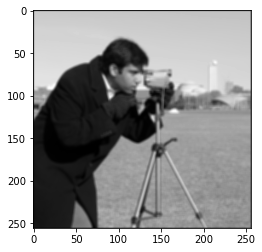

In [144]:
plt.imshow(camera_blurred, cmap='gray')

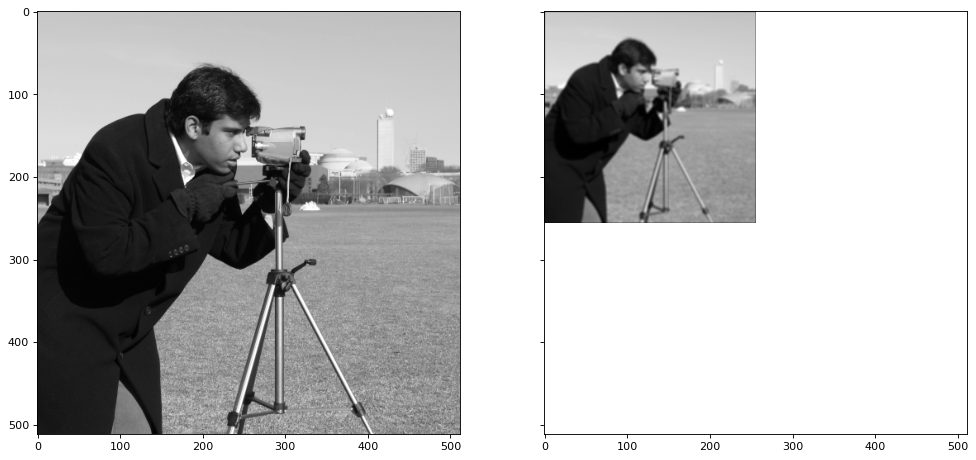

In [145]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=80, sharey=True, sharex=True)
ax[1].imshow(camera_blurred, cmap='gray')
ax[0].imshow(camera, cmap='gray')

The result image is 128x128 vs. 512x512 for the input image (even if matlplotlib displays with the same physical size) and has its details blurred.


### 3. Deblurring
We have $y=Bx$. Choosing $x^* = B_R^{-1}y$, where $B_R^{-1}$ is the right-inverse of $B$ yields to $Bx^* = BB_R^{-1}y = y$. 

$x^*$ is a valid input that will generate the blurred output.

Right inverse is $A^T(AA^T)^{-1}$

In [146]:
Ar_inv = B.T@np.linalg.inv(B@B.T)

In [147]:
# reconstruct rows
camera_unblur_row = (Ar_inv@camera_blurred.T).T
camera_unblur_row = camera_blurred@Ar_inv.T

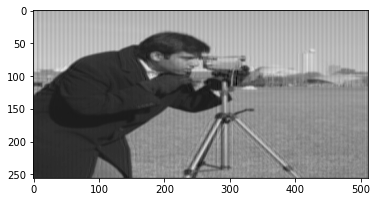

In [148]:
plt.imshow(camera_unblur_row, cmap='gray')

In [149]:
# reconstruct columns
camera_unblur = Ar_inv@camera_unblur_row

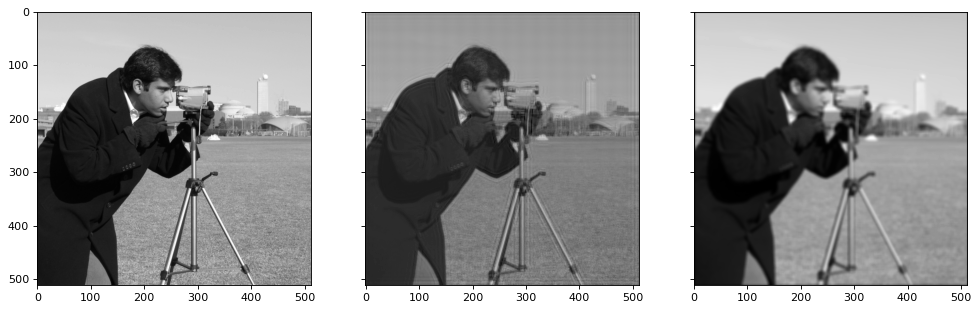

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7), dpi=80, sharey=True, sharex=True)
ax[1].imshow(camera_unblur, cmap='gray')
ax[0].imshow(camera, cmap='gray')
ax[2].imshow(skimage.transform.resize(camera_blurred, (512,512)), cmap='gray')

We can see that the image reconstruction (center image, original on left) is not perfect (that would be too easy). While some details are restored, the result suffers from a fair amount of distortion. However just scaling up the blurred image (rightmost image) is clearly worse.

However if we recompute the blurred version using the output of our deblurring method:

In [93]:
tmp = B@camera_unblur
camera_reblur = (B@tmp.T).T

In [94]:
diff = (camera_reblur - camera_blurred)

In [95]:
np.max(diff)

1.887379141862766e-15

In [96]:
np.min(diff)

-1.6653345369377348e-15

We can see that while $x^*$ is a valid solution, it is (by far) not the optimal one ! As the matrix $B$ is only onto (and not 1-1) we will have several admissible solutions that satisfy $y=Bx$. The right inverse is only one of them.